<a href="https://colab.research.google.com/github/mobarakol/DL_Robotic_AI/blob/main/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/Tech-Watt/Faster-RCNN-PYTORCH.git
%cd Faster-RCNN-PYTORCH

Cloning into 'Faster-RCNN-PYTORCH'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 922.23 KiB | 11.67 MiB/s, done.
/content/Faster-RCNN-PYTORCH


In [1]:
!pip -q install cvzone

  Preparing metadata (setup.py) ... done


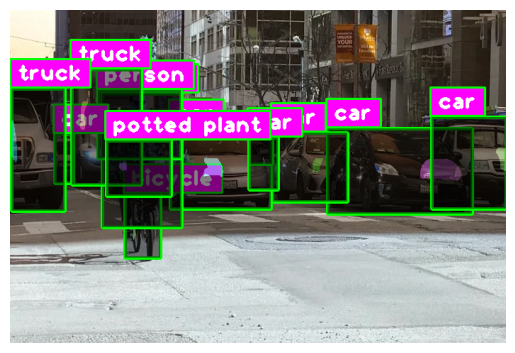

In [6]:
import torch
import cv2
import cvzone
import numpy as np
import requests
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
from PIL import Image

# Load the Mask R-CNN model (pre-trained on COCO)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load class names (COCO dataset has 91 classes)
classnames = []
with open('classes.txt', 'r') as f:
    classnames = f.read().splitlines()

# URL of the image
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"

# Fetch the image and resize it
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
image = np.array(image)
original_image = image.copy()  # Keep a copy of the original image for overlay
height, width, _ = image.shape

# Convert image to tensor
image_transform = transforms.ToTensor()
img_tensor = image_transform(image)

# Perform inference
with torch.no_grad():
    pred = model([img_tensor])
    boxes, scores, labels, masks = pred[0]['boxes'], pred[0]['scores'], pred[0]['labels'], pred[0]['masks']

# Set confidence threshold
conf_threshold = 0.70
num_detections = (scores > conf_threshold).sum().item()

# Loop over detections
for i in range(num_detections):
    # Get bounding box
    x, y, w, h = boxes[i].numpy().astype('int')

    # Get class name
    classname = labels[i].numpy().astype('int')
    class_detected = classnames[classname] if classname < len(classnames) else "Unknown"

    # Draw bounding box
    cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 3)
    cvzone.putTextRect(image, class_detected, [x+8, y-12], scale=2, border=2)

    # Extract and process the mask
    mask = masks[i, 0].cpu().numpy()  # Convert from PyTorch tensor to NumPy
    mask = (mask > 0.5).astype(np.uint8) * 255  # Apply threshold (binary mask)

    # Resize mask to bounding box size
    mask_resized = cv2.resize(mask, (w - x, h - y))

    # Create colored mask overlay
    color = np.random.randint(0, 255, (1, 3), dtype=np.uint8).tolist()[0]
    color_mask = np.zeros_like(original_image[y:h, x:w], dtype=np.uint8)
    color_mask[mask_resized > 128] = color  # Apply color only where mask exists

    # Blend original image with mask (Alpha Blending)
    alpha = 0.5
    image[y:h, x:w] = cv2.addWeighted(image[y:h, x:w], 1 - alpha, color_mask, alpha, 0)

# Save and display the output image
cv2.imwrite('mask_rcnn_output.png', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


Using device: cuda


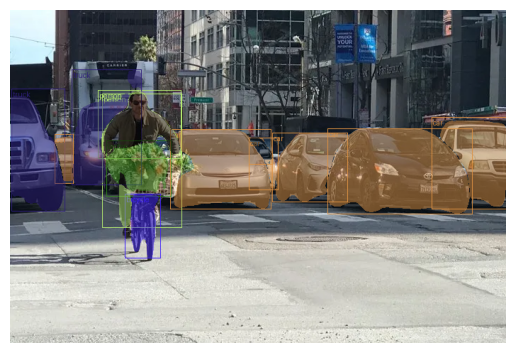

In [24]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained Mask R-CNN model and move it to the GPU
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Download an image from a URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Preprocess the image
image_tensor = F.to_tensor(image)  # Convert PIL image to tensor
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred = predictions[0]  # Get predictions for the first (and only) image
boxes = pred["boxes"].cpu()  # Move boxes to CPU for visualization
labels = pred["labels"].cpu()  # Move labels to CPU for visualization
scores = pred["scores"].cpu()  # Move scores to CPU for visualization
masks = pred["masks"].cpu()  # Move masks to CPU for visualization

# Filter predictions by confidence score
confidence_threshold = 0.7
keep = scores > confidence_threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]
masks = masks[keep]

# Convert masks to binary format and remove the extra channel dimension
masks = (masks > 0.5).squeeze(1)  # Shape: (N, H, W)

# Map COCO class IDs to class names
coco_class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

# Define a color map for different classes
def generate_color_map(num_classes):
    """Generate a random color map for the given number of classes."""
    color_map = {}
    for i in range(num_classes):
        color_map[i] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color_map

# Generate a color map for COCO classes
num_classes = len(coco_class_names)
color_map = generate_color_map(num_classes)

# Assign colors to bounding boxes and masks based on class labels
box_colors = [color_map[label.item() - 1] for label in labels]  # Subtract 1 because COCO labels start at 1
mask_colors = [color_map[label.item() - 1] for label in labels]

# Draw bounding boxes and masks on the image
image_tensor = (image_tensor.squeeze(0).cpu() * 255).byte()  # Move to CPU and convert to uint8 for visualization
image_with_boxes = draw_bounding_boxes(image_tensor, boxes, labels=[coco_class_names[label - 1] for label in labels], colors=box_colors)
image_with_masks = draw_segmentation_masks(image_with_boxes, masks, alpha=0.5, colors=mask_colors)

# Convert tensor back to PIL image for display
result_image = F.to_pil_image(image_with_masks)

# Display the result
plt.imshow(result_image)
plt.axis("off")
plt.show()

Using device: cuda
Box: [371.9143  173.57031 478.21637 272.37048], Class: bicycle
Box: [128.74956 116.48109 244.08156 222.22252], Class: __background__
Box: [441.7254  165.80598 646.75397 288.966  ], Class: bicycle
Box: [163.53821 253.6891  212.29774 354.69028], Class: person
Box: [220.92908 169.23051 371.0667  283.56573], Class: bicycle
Box: [ 63.00772 180.15202  89.68203 243.9695 ], Class: bicycle
Box: [337.4784  181.4749  370.58182 218.0656 ], Class: bicycle
Box: [176.03111 215.3217  191.73521 236.37575], Class: clock
Box: [601.0892 158.5094 700.     279.0959], Class: bicycle
Box: [336.14044 182.2684  377.19724 243.8578 ], Class: bicycle
Box: [  1.5282298 105.75245    73.11494   288.2208   ], Class: train
Box: [136.5748  186.29138 221.47356 249.54051], Class: couch
Box: [186.67908 224.4015  196.14647 241.94185], Class: clock
Box: [ 85.47352   72.961555 205.11612  242.09668 ], Class: train
Box: [158.95737 184.47946 209.22543 239.13112], Class: couch
Box: [170.07533  33.35732 208.8628

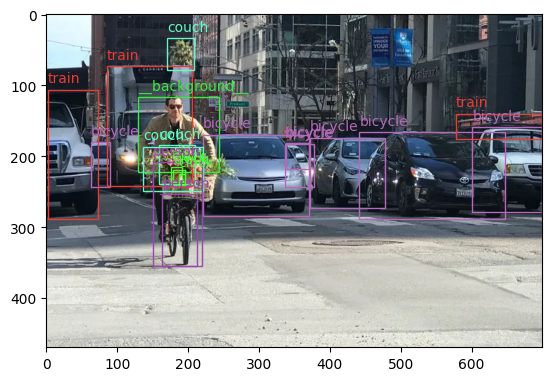

In [34]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Check for GPU availability
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Load the pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

# Image URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"

# Download and open the image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Apply transformations and add a batch dimension
img_tensor = transform(img).unsqueeze(0).to(device)

# Perform object detection
with torch.no_grad():
    predictions = model(img_tensor)

# Process the predictions
boxes = predictions[0]['boxes'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()

# Load class names from classes.txt
try:
    with open("classes.txt", "r") as f:
        class_names = [line.strip() for line in f]
except FileNotFoundError:
    print("Error: classes.txt not found.")
    exit()

# Generate random colors for each class
class_colors = {}
for class_name in class_names:
    class_colors[class_name] = (random.random(), random.random(), random.random())

# Visualize the results
fig, ax = plt.subplots(1)
ax.imshow(img)

for i in range(len(boxes)):
    if scores[i] > 0.5:
        label_index = labels[i] - 1
        if 0 <= label_index < len(class_names):  # Check if index is valid
            class_name = class_names[label_index]
            x1, y1, x2, y2 = boxes[i]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor=class_colors[class_name], facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 10, f"{class_name}", color=class_colors[class_name], backgroundcolor='none') # Set text color
            print(f"Box: {boxes[i]}, Class: {class_name}")
        else:
            print(f"Warning: Invalid label index {labels[i]}. Skipping detection.")

plt.show()

Using device: cuda


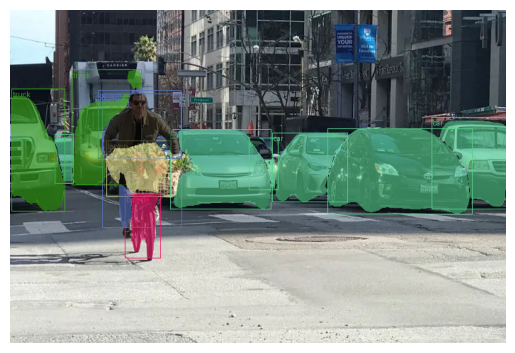

In [38]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained Mask R-CNN model and move it to the GPU
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Download an image from a URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Preprocess the image
image_tensor = F.to_tensor(image)  # Convert PIL image to tensor
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred = predictions[0]  # Get predictions for the first (and only) image
boxes = pred["boxes"].cpu()  # Move boxes to CPU for visualization
labels = pred["labels"].cpu()  # Move labels to CPU for visualization
scores = pred["scores"].cpu()  # Move scores to CPU for visualization
masks = pred["masks"].cpu()  # Move masks to CPU for visualization

# Filter predictions by confidence score
confidence_threshold = 0.7
keep = scores > confidence_threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]
masks = masks[keep]

# Convert masks to binary format and remove the extra channel dimension
masks = (masks > 0.5).squeeze(1)  # Shape: (N, H, W)

# Map COCO class IDs to class names
coco_class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

# Define a color map for different classes
def generate_color_map(num_classes):
    """Generate a random color map for the given number of classes."""
    color_map = {}
    for i in range(num_classes):
        color_map[i] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color_map

# Generate a color map for COCO classes
num_classes = len(coco_class_names)
color_map = generate_color_map(num_classes)

# Assign colors to bounding boxes and masks based on class labels
box_colors = [color_map[label.item() - 1] for label in labels]  # Subtract 1 because COCO labels start at 1
mask_colors = [color_map[label.item() - 1] for label in labels]

# Draw bounding boxes and masks on the image
image_tensor = (image_tensor.squeeze(0).cpu() * 255).byte()  # Move to CPU and convert to uint8 for visualization
image_with_boxes = draw_bounding_boxes(image_tensor, boxes, labels=[coco_class_names[label - 1] for label in labels], colors=box_colors)
image_with_masks = draw_segmentation_masks(image_with_boxes, masks, alpha=0.60, colors=mask_colors)

# Convert tensor back to PIL image for display
result_image = F.to_pil_image(image_with_masks)

# Display the result
plt.imshow(result_image)
plt.axis("off")
plt.show()

Using device: cuda


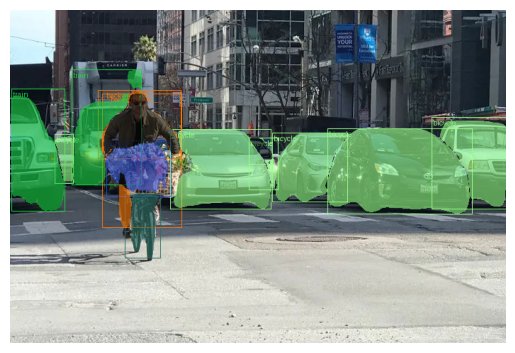

In [41]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained Mask R-CNN model and move it to the GPU
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Download an image from a URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Preprocess the image
image_tensor = F.to_tensor(image)  # Convert PIL image to tensor
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred = predictions[0]  # Get predictions for the first (and only) image
boxes = pred["boxes"].cpu()  # Move boxes to CPU for visualization
labels = pred["labels"].cpu()  # Move labels to CPU for visualization
scores = pred["scores"].cpu()  # Move scores to CPU for visualization
masks = pred["masks"].cpu()  # Move masks to CPU for visualization

# Filter predictions by confidence score
confidence_threshold = 0.7
keep = scores > confidence_threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]
masks = masks[keep]

# Convert masks to binary format and remove the extra channel dimension
masks = (masks > 0.5).squeeze(1)  # Shape: (N, H, W)

# Function to read COCO class names from a file
def read_coco_classes(file_path):
    """Read COCO class names from a text file."""
    with open(file_path, "r") as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

# Path to the COCO classes file
coco_classes_file = "classes.txt"  # Replace with the path to your file

# Read COCO class names from the file
coco_class_names = read_coco_classes(coco_classes_file)

# Define a color map for different classes
def generate_color_map(num_classes):
    """Generate a random color map for the given number of classes."""
    color_map = {}
    for i in range(num_classes):
        color_map[i] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color_map

# Generate a color map for COCO classes
num_classes = len(coco_class_names)
color_map = generate_color_map(num_classes)

# Assign colors to bounding boxes and masks based on class labels
box_colors = [color_map[label.item() - 1] for label in labels]  # Subtract 1 because COCO labels start at 1
mask_colors = [color_map[label.item() - 1] for label in labels]

# Draw bounding boxes and masks on the image
image_tensor = (image_tensor.squeeze(0).cpu() * 255).byte()  # Move to CPU and convert to uint8 for visualization
image_with_boxes = draw_bounding_boxes(image_tensor, boxes, labels=[coco_class_names[label - 1] for label in labels], colors=box_colors)
image_with_masks = draw_segmentation_masks(image_with_boxes, masks, alpha=0.6, colors=mask_colors)

# Convert tensor back to PIL image for display
result_image = F.to_pil_image(image_with_masks)

# Display the result
plt.imshow(result_image)
plt.axis("off")
plt.show()

Using device: cuda


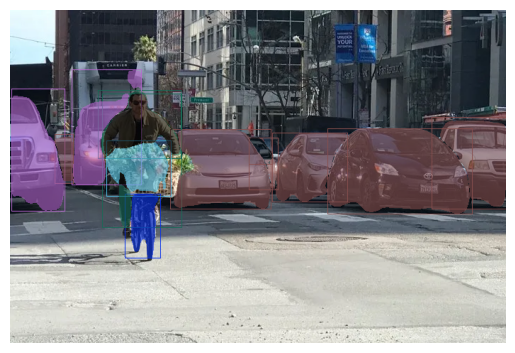

In [43]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained Mask R-CNN model and move it to the GPU
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Download an image from a URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Preprocess the image
image_tensor = F.to_tensor(image)  # Convert PIL image to tensor
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred = predictions[0]  # Get predictions for the first (and only) image
boxes = pred["boxes"].cpu()  # Move boxes to CPU for visualization
labels = pred["labels"].cpu()  # Move labels to CPU for visualization
scores = pred["scores"].cpu()  # Move scores to CPU for visualization
masks = pred["masks"].cpu()  # Move masks to CPU for visualization

# Filter predictions by confidence score
confidence_threshold = 0.7
keep = scores > confidence_threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]
masks = masks[keep]

# Convert masks to binary format and remove the extra channel dimension
masks = (masks > 0.5).squeeze(1)  # Shape: (N, H, W)

# Function to read COCO class names from a file
def read_coco_classes(file_path):
    """Read COCO class names from a text file."""
    with open(file_path, "r") as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

# Path to the COCO classes file
coco_classes_file = "classes.txt"  # Replace with the path to your file

# Read COCO class names from the file
coco_class_names = read_coco_classes(coco_classes_file)

# Define a color map for different classes
def generate_color_map(num_classes):
    """Generate a random color map for the given number of classes."""
    color_map = {}
    for i in range(num_classes):
        color_map[i] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color_map

# Generate a color map for COCO classes
num_classes = len(coco_class_names)
color_map = generate_color_map(num_classes)

# Assign colors to bounding boxes and masks based on class labels
box_colors = [color_map[label.item() - 1] for label in labels]  # Subtract 1 because COCO labels start at 1
mask_colors = [color_map[label.item() - 1] for label in labels]

# Draw bounding boxes and masks on the image
image_tensor = (image_tensor.squeeze(0).cpu() * 255).byte()  # Move to CPU and convert to uint8 for visualization
image_with_boxes = draw_bounding_boxes(image_tensor, boxes, colors=box_colors)  # No labels
image_with_masks = draw_segmentation_masks(image_with_boxes, masks, alpha=0.6, colors=mask_colors)

# Convert tensor back to PIL image for display
result_image = F.to_pil_image(image_with_masks)

# Display the result
plt.imshow(result_image)
plt.axis("off")
plt.show()

Using device: cuda


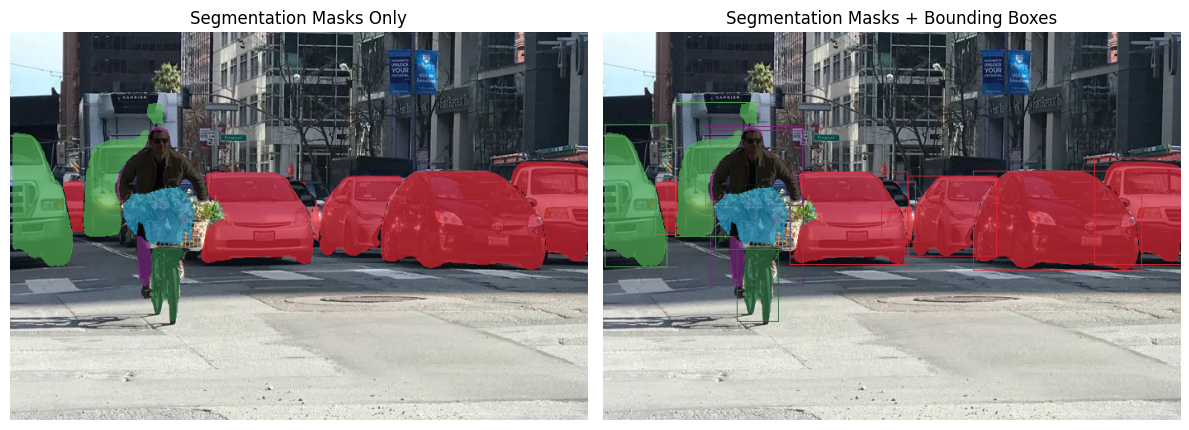

In [44]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained Mask R-CNN model and move it to the GPU
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Download an image from a URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Preprocess the image
image_tensor = F.to_tensor(image)  # Convert PIL image to tensor
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred = predictions[0]  # Get predictions for the first (and only) image
boxes = pred["boxes"].cpu()  # Move boxes to CPU for visualization
labels = pred["labels"].cpu()  # Move labels to CPU for visualization
scores = pred["scores"].cpu()  # Move scores to CPU for visualization
masks = pred["masks"].cpu()  # Move masks to CPU for visualization

# Filter predictions by confidence score
confidence_threshold = 0.7
keep = scores > confidence_threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]
masks = masks[keep]

# Convert masks to binary format and remove the extra channel dimension
masks = (masks > 0.5).squeeze(1)  # Shape: (N, H, W)

# Function to read COCO class names from a file
def read_coco_classes(file_path):
    """Read COCO class names from a text file."""
    with open(file_path, "r") as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

# Path to the COCO classes file
coco_classes_file = "classes.txt"  # Replace with the path to your file

# Read COCO class names from the file
coco_class_names = read_coco_classes(coco_classes_file)

# Define a color map for different classes
def generate_color_map(num_classes):
    """Generate a random color map for the given number of classes."""
    color_map = {}
    for i in range(num_classes):
        color_map[i] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color_map

# Generate a color map for COCO classes
num_classes = len(coco_class_names)
color_map = generate_color_map(num_classes)

# Assign colors to bounding boxes and masks based on class labels
box_colors = [color_map[label.item() - 1] for label in labels]  # Subtract 1 because COCO labels start at 1
mask_colors = [color_map[label.item() - 1] for label in labels]

# Convert tensor back to uint8 for visualization
image_tensor = (image_tensor.squeeze(0).cpu() * 255).byte()

# Create the first visualization: Only segmentation masks
image_with_masks_only = draw_segmentation_masks(image_tensor, masks, alpha=0.7, colors=mask_colors)

# Create the second visualization: Segmentation masks and bounding boxes
image_with_boxes = draw_bounding_boxes(image_tensor, boxes, colors=box_colors)
image_with_masks_and_boxes = draw_segmentation_masks(image_with_boxes, masks, alpha=0.7, colors=mask_colors)

# Convert tensors back to PIL images for display
result_image_masks_only = F.to_pil_image(image_with_masks_only)
result_image_masks_and_boxes = F.to_pil_image(image_with_masks_and_boxes)

# Display the results side by side
plt.figure(figsize=(12, 6))

# Plot the first result: Only segmentation masks
plt.subplot(1, 2, 1)
plt.imshow(result_image_masks_only)
plt.title("Segmentation Masks Only")
plt.axis("off")

# Plot the second result: Segmentation masks and bounding boxes
plt.subplot(1, 2, 2)
plt.imshow(result_image_masks_and_boxes)
plt.title("Segmentation Masks + Bounding Boxes")
plt.axis("off")

plt.tight_layout()
plt.show()

Using device: cuda


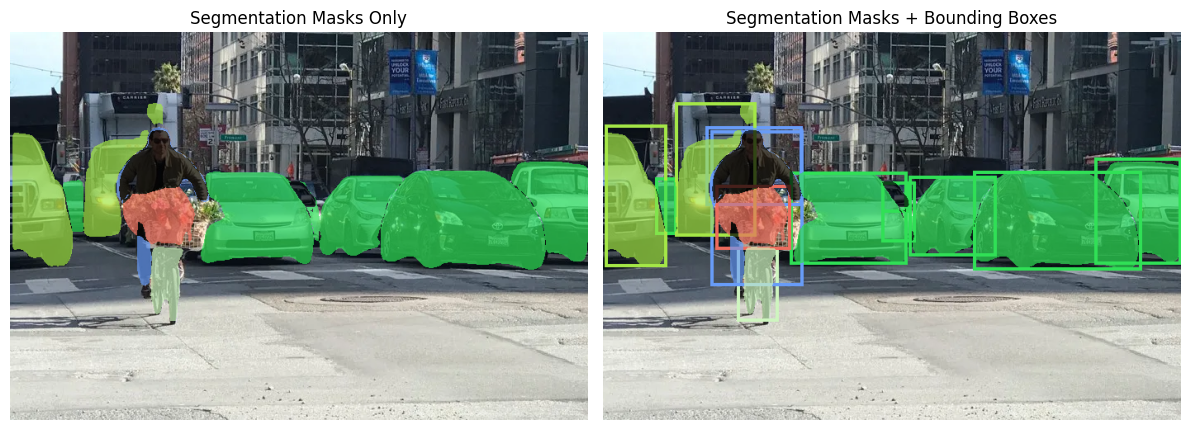

In [45]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained Mask R-CNN model and move it to the GPU
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Download an image from a URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Preprocess the image
image_tensor = F.to_tensor(image)  # Convert PIL image to tensor
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred = predictions[0]  # Get predictions for the first (and only) image
boxes = pred["boxes"].cpu()  # Move boxes to CPU for visualization
labels = pred["labels"].cpu()  # Move labels to CPU for visualization
scores = pred["scores"].cpu()  # Move scores to CPU for visualization
masks = pred["masks"].cpu()  # Move masks to CPU for visualization

# Filter predictions by confidence score
confidence_threshold = 0.7
keep = scores > confidence_threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]
masks = masks[keep]

# Convert masks to binary format and remove the extra channel dimension
masks = (masks > 0.5).squeeze(1)  # Shape: (N, H, W)

# Function to read COCO class names from a file
def read_coco_classes(file_path):
    """Read COCO class names from a text file."""
    with open(file_path, "r") as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

# Path to the COCO classes file
coco_classes_file = "classes.txt"  # Replace with the path to your file

# Read COCO class names from the file
coco_class_names = read_coco_classes(coco_classes_file)

# Define a color map for different classes
def generate_color_map(num_classes):
    """Generate a random color map for the given number of classes."""
    color_map = {}
    for i in range(num_classes):
        color_map[i] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color_map

# Generate a color map for COCO classes
num_classes = len(coco_class_names)
color_map = generate_color_map(num_classes)

# Assign colors to bounding boxes and masks based on class labels
box_colors = [color_map[label.item() - 1] for label in labels]  # Subtract 1 because COCO labels start at 1
mask_colors = [color_map[label.item() - 1] for label in labels]

# Convert tensor back to uint8 for visualization
image_tensor = (image_tensor.squeeze(0).cpu() * 255).byte()

# Create the first visualization: Only segmentation masks
image_with_masks_only = draw_segmentation_masks(image_tensor, masks, alpha=0.7, colors=mask_colors)

# Create the second visualization: Segmentation masks and bounding boxes with increased thickness
image_with_boxes = draw_bounding_boxes(image_tensor, boxes, colors=box_colors, width=4)  # Increase thickness here
image_with_masks_and_boxes = draw_segmentation_masks(image_with_boxes, masks, alpha=0.7, colors=mask_colors)

# Convert tensors back to PIL images for display
result_image_masks_only = F.to_pil_image(image_with_masks_only)
result_image_masks_and_boxes = F.to_pil_image(image_with_masks_and_boxes)

# Display the results side by side
plt.figure(figsize=(12, 6))

# Plot the first result: Only segmentation masks
plt.subplot(1, 2, 1)
plt.imshow(result_image_masks_only)
plt.title("Segmentation Masks Only")
plt.axis("off")

# Plot the second result: Segmentation masks and bounding boxes
plt.subplot(1, 2, 2)
plt.imshow(result_image_masks_and_boxes)
plt.title("Segmentation Masks + Bounding Boxes")
plt.axis("off")

plt.tight_layout()
plt.show()

Using device: cuda


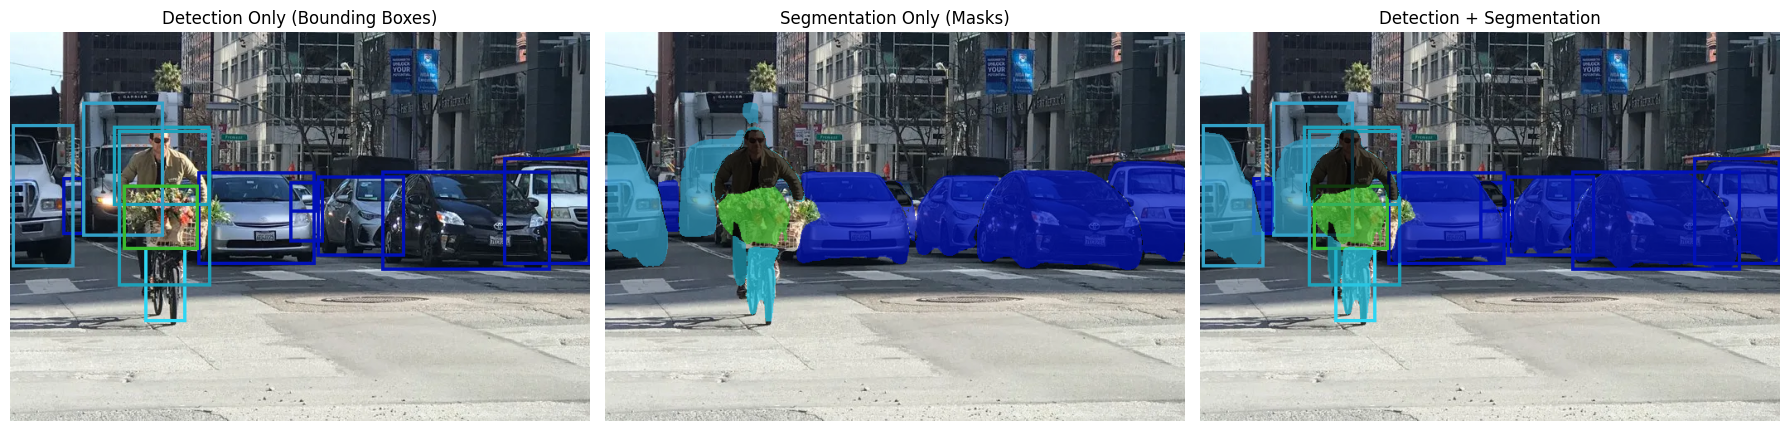

In [46]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained Mask R-CNN model and move it to the GPU
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Download an image from a URL
image_url = "https://miro.medium.com/v2/resize:fit:720/format:webp/0*375hJ4bJsG1lq36K.jpeg"
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert("RGB")

# Preprocess the image
image_tensor = F.to_tensor(image)  # Convert PIL image to tensor
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred = predictions[0]  # Get predictions for the first (and only) image
boxes = pred["boxes"].cpu()  # Move boxes to CPU for visualization
labels = pred["labels"].cpu()  # Move labels to CPU for visualization
scores = pred["scores"].cpu()  # Move scores to CPU for visualization
masks = pred["masks"].cpu()  # Move masks to CPU for visualization

# Filter predictions by confidence score
confidence_threshold = 0.7
keep = scores > confidence_threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]
masks = masks[keep]

# Convert masks to binary format and remove the extra channel dimension
masks = (masks > 0.5).squeeze(1)  # Shape: (N, H, W)

# Function to read COCO class names from a file
def read_coco_classes(file_path):
    """Read COCO class names from a text file."""
    with open(file_path, "r") as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

# Path to the COCO classes file
coco_classes_file = "classes.txt"  # Replace with the path to your file

# Read COCO class names from the file
coco_class_names = read_coco_classes(coco_classes_file)

# Define a color map for different classes
def generate_color_map(num_classes):
    """Generate a random color map for the given number of classes."""
    color_map = {}
    for i in range(num_classes):
        color_map[i] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color_map

# Generate a color map for COCO classes
num_classes = len(coco_class_names)
color_map = generate_color_map(num_classes)

# Assign colors to bounding boxes and masks based on class labels
box_colors = [color_map[label.item() - 1] for label in labels]  # Subtract 1 because COCO labels start at 1
mask_colors = [color_map[label.item() - 1] for label in labels]

# Convert tensor back to uint8 for visualization
image_tensor = (image_tensor.squeeze(0).cpu() * 255).byte()

# Create the first visualization: Detection only (bounding boxes)
image_with_boxes_only = draw_bounding_boxes(image_tensor, boxes, colors=box_colors, width=4)  # Increased thickness

# Create the second visualization: Segmentation only (masks)
image_with_masks_only = draw_segmentation_masks(image_tensor, masks, alpha=0.7, colors=mask_colors)

# Create the third visualization: Detection and segmentation combined
image_with_boxes = draw_bounding_boxes(image_tensor, boxes, colors=box_colors, width=4)  # Increased thickness
image_with_masks_and_boxes = draw_segmentation_masks(image_with_boxes, masks, alpha=0.7, colors=mask_colors)

# Convert tensors back to PIL images for display
result_image_boxes_only = F.to_pil_image(image_with_boxes_only)
result_image_masks_only = F.to_pil_image(image_with_masks_only)
result_image_masks_and_boxes = F.to_pil_image(image_with_masks_and_boxes)

# Display the results in a single figure
plt.figure(figsize=(18, 6))

# Plot the first result: Detection only (bounding boxes)
plt.subplot(1, 3, 1)
plt.imshow(result_image_boxes_only)
plt.title("Detection Only (Bounding Boxes)")
plt.axis("off")

# Plot the second result: Segmentation only (masks)
plt.subplot(1, 3, 2)
plt.imshow(result_image_masks_only)
plt.title("Segmentation Only (Masks)")
plt.axis("off")

# Plot the third result: Detection and segmentation combined
plt.subplot(1, 3, 3)
plt.imshow(result_image_masks_and_boxes)
plt.title("Detection + Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()